In [1]:
from deep_traffic_generation.rae import RAE
from deep_traffic_generation.core.datasets import TrafficDataset
from deep_traffic_generation.core.utils import traffic_from_data

from sklearn.preprocessing import MinMaxScaler
from sklearn.manifold import TSNE

import matplotlib.pyplot as plt
import numpy as np

from traffic.core.projection import EuroPP

import torch

import warnings
warnings.filterwarnings("ignore")

In [2]:
dataset = TrafficDataset.from_file(
    "../../deep_traffic_generation/data/traffic_15.pkl",
    features=["latitude", "longitude", "altitude", "timedelta"],
    scaler=MinMaxScaler(feature_range=(-1,1)),
    shape="sequence",
)
dataset

Dataset TrafficDataset
    Number of datapoints: 3968
    MinMaxScaler(feature_range=(-1, 1))

In [3]:
model = RAE.load_from_checkpoint(
    "../../deep_traffic_generation/lightning_logs/rae/version_0/checkpoints/epoch=91-step=275.ckpt",
    hparams_file="../../deep_traffic_generation/lightning_logs/rae/version_0/hparams.yaml",
    dataset_params=dataset.parameters,
)
model.eval()

RAE(
  (encoder): RNN(
    (layers): ModuleList(
      (0): LSTM(4, 64, batch_first=True)
      (1): LSTM(64, 32, batch_first=True)
      (2): LSTM(32, 16, batch_first=True)
    )
  )
  (decoder): RNN(
    (layers): ModuleList(
      (0): LSTM(16, 16, batch_first=True)
      (1): LSTM(16, 32, batch_first=True)
      (2): LSTM(32, 64, batch_first=True)
      (3): LSTM(64, 4, batch_first=True)
    )
  )
  (out_activ): Tanh()
)

In [4]:
_, (h, _) = model.encoder(dataset.data)
z = h.squeeze(0)
z.size()

torch.Size([3968, 16])

In [5]:
z_array = z.detach().cpu().numpy()
z_array.shape

(3968, 16)

In [6]:
z_embedded = TSNE(n_components=2).fit_transform(z_array)
z_embedded.shape

(3968, 2)

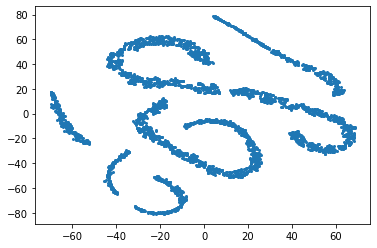

In [7]:
plt.scatter(z_embedded[:, 0], z_embedded[:, 1], s=4)
plt.show()

In [8]:
x, _ = dataset[0]
x = x.unsqueeze(0)
z, x_hat = model(x)

In [9]:
x.size()

torch.Size([1, 200, 4])

In [10]:
x_hat.size()

torch.Size([1, 200, 4])

In [11]:
z.size()

torch.Size([1, 16])

In [12]:
data = np.concatenate((x.numpy(), x_hat.detach().numpy()))
data = data.reshape((data.shape[0], -1))
data = dataset.scaler.inverse_transform(data)
data.shape

(2, 800)

In [13]:
builder = model.get_builder(data.shape[0], dataset.seq_len)
features = [
    "track" if "track" in f else f for f in model.hparams.features
]
traffic = traffic_from_data(
    data, features, model.dataset_params["info_params"]["features"], builder=builder
)
traffic

,count
flight_id,
TRAJ_0,200
TRAJ_1,200


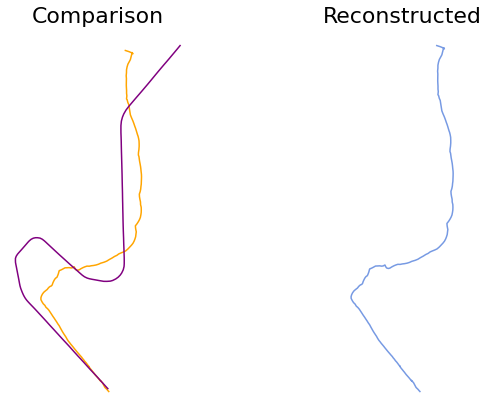

In [14]:
with plt.style.context("traffic"):
    fig, ax = plt.subplots(1, 2, subplot_kw=dict(projection=EuroPP()))
    ax[0].set_title("Comparison")
    traffic[1].plot(ax[0], c="orange", label="reconstructed")
    traffic[0].plot(ax[0], c="purple", label="original")
    ax[1].set_title("Reconstructed")
    traffic[1].plot(ax[1])

    plt.show()